# 7章 ロジスティクスネットワークの最適設計を行う10本ノック

ここでは、最適化計算を行ういくつかのライブラリを用いて、最適化計算を実際に行っていきます。  
そして、前章で用いたネットワーク可視化などの技術を駆使し、計算結果の妥当性を確認する方法についても学んでいきます。

### ノック６１：輸送最適化問題を解いてみよう

In [11]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

# データ読み込み
df_tc = pd.read_csv('trans_cost.csv', index_col="工場")
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

# 初期設定 # 
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))

#数理モデル作成#
m1 = model_min()
v1 = {(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}

m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
for i in range(nw):
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
m1.solve()

# 総輸送コスト計算 #
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j]*value(x)
    
print(df_tr_sol)
print("総輸送コスト："+str(total_cost))

    F1  F2  F3  F4
工場                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
総輸送コスト：1296.0


### ノック６２：最適輸送ルートをネットワークで確認しよう

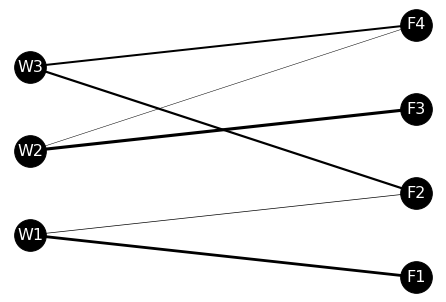

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# データ読み込み
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv('trans_route_pos.csv')

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 辺の設定、エッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not(i==j):
            # 辺の追加
            G.add_edge(df_pos.columns[i], df_pos.columns[j])
            # エッジの重みの追加
            if num_pre < len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif (df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)

# 座標の設定
pos = {}
for i in range (len(df_pos.columns)):
    node= df_pos.columns[i]
    pos[node] = (df_pos[node][0], df_pos[node][1])
    
# 描画
nx.draw(G, pos, with_labels=True, font_size=16,node_size=1000, node_color='k', font_color='w',width=edge_weights)

# 表示
plt.show()

### ノック６３：最適輸送ルートが制約条件内に収まっているかどうかを確認しよう

In [14]:
import pandas as pd
import numpy as np

# データ読み込み
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

# 制約条件計算関数
# 需要側
def condition_demand(dt_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag

# 供給側
def condition_supply(df_tr, df_supply):
    flag= np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

print("需要条件計算結果:"+str(condition_demand(df_tr_sol, df_demand)))
print("供給条件計算結果:"+str(condition_supply(df_tr_sol, df_supply)))

需要条件計算結果:[1. 1. 1. 1.]
供給条件計算結果:[1. 1. 1.]


### ノック６４：生産計画に関するデータを読み込んでみよう

In [17]:
import pandas as pd

df_material = pd.read_csv('product_plan_material.csv',index_col="製品")
print(df_material)
df_profit = pd.read_csv('product_plan_profit.csv',index_col="製品")
print(df_profit)
df_stock = pd.read_csv('product_plan_stock.csv',index_col="項目")
print(df_stock)
df_plan = pd.read_csv('product_plan.csv',index_col="製品")
print(df_plan)

     原料1  原料2  原料3
製品                
製品1    1    4    3
製品2    2    4    1
      利益
製品      
製品1  5.0
製品2  4.0
    原料1  原料2  原料3
項目               
在庫   40   80   50
      生産量
製品       
製品1    16
製品2     0


### ノック６５：利益を計算する関数を作ってみよう

In [19]:
def product_plan(df_profit,df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        for j in range(len(df_plan.columns)):
            profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
    return profit

print("純利益:"+str(product_plan(df_profit, df_plan)))

純利益:80.0


### ノック６６：生産最適化問題を解いてみよう

In [22]:
import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

df = df_material.copy()
inv = df_stock

m = model_max()
v1 = {(i):LpVariable('v%d'%(i),lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))
for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit))) <= df_stock.iloc[:,i]
m.solve()

df_plan_sol = df_plan.copy()
for k,x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("総利益："+str(value(m.objective)))

      生産量
製品       
製品1  15.0
製品2   5.0
総利益：95.0


### ノック６７：最適生産計画が制約条件内に収まっているかどうかを確認しよう

In [26]:
def condition_stock(df_plan,df_material,df_stock):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):
        temp_sum = 0
        for j in range(len(df_material.index)):
            temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
        if (temp_sum<=float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i] + " 使用量:"+str(temp_sum)+", 在庫:"+str(float(df_stock.iloc[0][i])))
    return flag

print("制約条件計算結果:"+str(condition_stock(df_plan_sol, df_material,df_stock)))

原料1 使用量:25.0, 在庫:40.0
原料2 使用量:80.0, 在庫:80.0
原料3 使用量:50.0, 在庫:50.0
制約条件計算結果:[1. 1. 1.]


### ノック６８：ロジスティクスネットワーク設計問題を解いてみよう

In [29]:
import numpy as np
import pandas as pd

製品 = list('AB')
需要地 = list('PQ')
工場 = list('XY')
レーン = (2,2)

# 輸送費表 #
tbdi = pd.DataFrame(((j,k) for j in 需要地 for k in 工場),columns=['需要地','工場'])
tbdi['輸送費'] = [1,2,3,1]
print(tbdi)

# 需要表 #
tbde = pd.DataFrame(((j,i) for j in 需要地 for i in 製品),columns=['需要地','製品'])
tbde['需要'] = [10,10,20,20]
print(tbde)

# 生産表 #
tbfa = pd.DataFrame(((k,1,i,0,np.inf) for k,nl in zip(工場,レーン) for l in range(nl) for i in 製品), columns=['工場','レーン','製品','下限','上限'])
tbfa['生産費'] = [1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,'上限']=10
print(tbfa)

from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde,tbdi,tbfa)
print(tbfa)
print(tbdi2)

  需要地 工場  輸送費
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  需要地 製品  需要
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  工場  レーン 製品  下限    上限  生産費
0  X    1  A   0   inf  1.0
3  X    1  B   0   inf  1.0
4  Y    1  A   0  10.0  3.0
6  Y    1  A   0   inf  5.0
7  Y    1  B   0   inf  3.0
  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    1  A   0   inf  1.0  v000022  20.0
3  X    1  B   0   inf  1.0  v000023  10.0
4  Y    1  A   0  10.0  3.0  v000024  10.0
6  Y    1  A   0   inf  5.0  v000025   0.0
7  Y    1  B   0   inf  3.0  v000026  20.0
  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000014  10.0
1   P  X    1  B  v000015  10.0
2   Q  X    3  A  v000016  10.0
3   Q  X    3  B  v000017   0.0
4   P  Y    2  A  v000018   0.0
5   P  Y    2  B  v000019   0.0
6   Q  Y    1  A  v000020  10.0
7   Q  Y    1  B  v000021  20.0


### ノック６９：最適ネットワークにおける輸送コストとその内訳を計算しよう

In [30]:
print(tbdi2)
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2["輸送費"].iloc[i]*tbdi2["ValX"].iloc[i]
print("総輸送コスト："+str(trans_cost))

  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000014  10.0
1   P  X    1  B  v000015  10.0
2   Q  X    3  A  v000016  10.0
3   Q  X    3  B  v000017   0.0
4   P  Y    2  A  v000018   0.0
5   P  Y    2  B  v000019   0.0
6   Q  Y    1  A  v000020  10.0
7   Q  Y    1  B  v000021  20.0
総輸送コスト：80.0


### ノック７０：最適ネットワークにおける生産コストとその内訳を計算しよう

In [31]:
print(tbfa)
product_cost = 0
for i in range(len(tbfa.index)):
    product_cost += tbfa["生産費"].iloc[i]*tbfa["ValY"].iloc[i]
print("総生産コスト："+str(product_cost))

  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    1  A   0   inf  1.0  v000022  20.0
3  X    1  B   0   inf  1.0  v000023  10.0
4  Y    1  A   0  10.0  3.0  v000024  10.0
6  Y    1  A   0   inf  5.0  v000025   0.0
7  Y    1  B   0   inf  3.0  v000026  20.0
総生産コスト：120.0
